In [ ]:
import config_imports
from astropy import units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, TEME
from astropy.time import Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


def to_datetime(eos_data: pd.DataFrame):
    eos_data["Datetime"] = eos_data[["Date", "Time", "Time since start (s)"]].apply(lambda x: datetime.datetime.fromisoformat(
        x.iloc[0] + "T" + x.iloc[1] + "Z") + datetime.timedelta(seconds=x.iloc[2] % 1.0), axis=1)
    eos_data = eos_data.drop(columns=["Date", "Time", "Time since start (s)"])
    return eos_data.set_index("Datetime", inplace=False)


eos_data_raw = pd.read_csv(r"EOS Sim Data\Sim2\sat_kinematic_state.CSV")


eos_data = eos_data_raw.drop(columns=["M11", "M12", "M13", "M21", "M22", "M23", "M31", "M32", "M33", 'M11.1', 'M12.1', 'M13.1', 'M21.1',
                                      'M22.1', 'M23.1', 'M31.1', 'M32.1', 'M33.1', 'X (deg/s).1', 'Y (deg/s).1', 'Z (deg/s).1'])

eos_data = to_datetime(eos_data).iloc[1:, :]
time = eos_data.index
time_passed_hours = (time - time[0]).total_seconds()/(3600)

eos_data.columns

quat_OB = eos_data[['Q1', 'Q2', 'Q3', 'Q4']]
quat_OB /= np.linalg.norm(quat_OB, axis=1, keepdims=True)

omega_BO_deg = eos_data[['X (deg/s)', 'Y (deg/s)', 'Z (deg/s)']]

euler_OB = eos_data[['Roll (deg)', 'Pitch (deg)', 'Yaw (deg)']]

pos = eos_data[['X (km)', 'Y (km)', 'Z (km)']]
vel = eos_data[['X (km/s)', 'Y (km/s)', 'Z (km/s)']]

geocentric = eos_data[['Geocentric Latitude (deg)',
                       'Geodetic Latitude (deg)', 'Altitude (km)']]

orbit_elements = eos_data[['Eccentricity', 'Semi-major Axis (km)',
                           'Inclination (deg)', 'Right-ascension of Ascending Node (deg)',
                           'Argument of Perigee (deg)', 'True Anomaly (deg)',
                           'Radius of Perigee (km)', 'Radius of Apogee (km)',
                           'Perigee Altitude (km)', 'Apogee Altitude (km)']]

orbit_ang_rate = eos_data['Orbit Angular Rate (deg/s)']
# convert from TEME to GCRS inertial frame


def teme_to_gcrs(t: datetime.datetime, x_TEME):
    teme = TEME(obstime=Time(t, format="datetime", scale="utc"))
    x_ECI = SkyCoord(CartesianRepresentation(x_TEME[:, 0], x_TEME[:, 1], x_TEME[:, 2], unit=u.km), frame=teme,
                     representation_type='cartesian').transform_to("gcrs").cartesian.xyz.to(u.m).value  # type: ignore
    return x_ECI.T


pos_arr = teme_to_gcrs(time, np.array(pos))
vel_arr = teme_to_gcrs(time, np.array(vel))

In [ ]:
plt.plot(time_passed_hours, pos_arr[:, 0]/1000 - np.array(pos)[:, 0])
# plt.plot((time - time[0]).total_seconds()/(3600), np.array(pos)[:, 0])

In [ ]:
aero_force = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\aero_force.CSV"))
aero_torque = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\aero_torque.CSV"))

srp_force = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\srp_force.CSV"))
srp_torque = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\srp_torque.CSV"))

qq_torque = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\gg_torque.CSV"))

In [488]:
import json
import os

from tqdm import tqdm
import environment as env
import disturbances as dis
from kinematics import eci_to_geodedic, orc_to_eci, orc_to_sbc, quaternion_kinematics, euler_ocr_to_sbc
from satellite import Spacecraft, replace_orientation_matrices
from simulation import Simulation, rk4_step
from scipy.spatial.transform import Rotation as R

with open(os.path.join(os.path.dirname(config_imports.HERE), "tudsat-trace_eos.json"), "r") as f:
            eos_file = json.load(f)

sim_init_data: dict = replace_orientation_matrices(eos_file) 

sim = Simulation.from_json(os.path.join(os.path.dirname(config_imports.HERE), "tudsat-trace_eos.json"))
sat = sim.sat

q_BI_true = np.empty((len(time), 4))

F_grav = np.empty((len(time), 3))
F_third = np.empty_like(F_grav)
tau_gg = np.empty_like(F_grav)
F_aero = np.empty_like(F_grav)
tau_aero =np.empty_like(F_grav)
F_SRP = np.empty_like(F_grav)
tau_SRP = np.empty_like(F_grav)

with tqdm(total=len(time), desc="Running") as pbar:
    for i, t in enumerate(time):


        q_BO_true = R.from_quat(quat_OB.iloc[i], scalar_first=False).inv()
        # orc_to_eci conversion is tested and good
        q_BI_true[i] = (q_BO_true * orc_to_eci(pos_arr[i], vel_arr[i]).inv()).as_quat(scalar_first=False)

        lat, lon, alt = eci_to_geodedic(pos_arr[i])
        
        rho = env.atmosphere_density_msis(t, lat, lon, alt)
        B = env.magnetic_field_vector(t, lat, lon, alt)
        sun_pos = env.sun_position(t)
        in_shadow = env.is_in_shadow(pos_arr[i], sun_pos)
        moon_pos = env.moon_position(t)

        F_grav[i] = dis.non_spherical_gravity_forces(pos_arr[i], sat.m)
        F_third[i] = dis.third_body_forces(pos_arr[i], sat.m, sun_pos, moon_pos)
        tau_gg[i] = dis.gravity_gradient(pos_arr[i], vel_arr[i], q_BI_true[i], sat.J_B)
        F_aero[i], tau_aero[i] = dis.aerodynamic_drag(pos_arr[i], vel_arr[i], q_BI_true[i], sat.surfaces, rho)
        F_SRP[i], tau_SRP[i] = dis.solar_radiation_pressure(pos_arr[i], sun_pos, in_shadow, q_BI_true[i], sat.surfaces)

        pbar.update()


Running: 100%|██████████| 30525/30525 [4:08:39<00:00,  2.05it/s]      


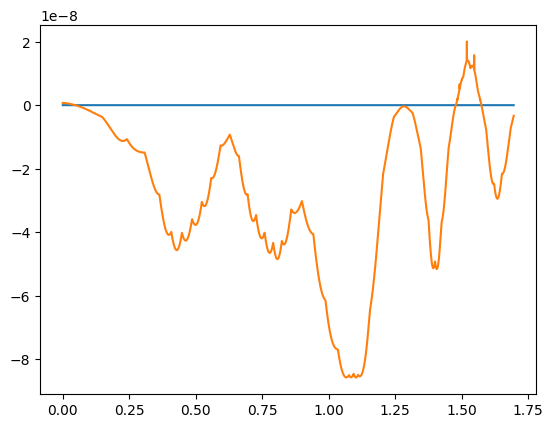

In [495]:
plt.plot(time_passed_hours, F_SRP[:, 2])
plt.plot(time_passed_hours, srp_force.iloc[:, 2])